Random forest


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
root
 |-- preg: integer (nullable = true)
 |-- plas: integer (nullable = true)
 |-- pres: integer (nullable = true)
 |-- skin: integer (nullable = true)
 |-- test: integer (nullable = true)
 |-- mass: double (nullable = true)
 |-- pedi: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- class: integer (nullable = true)

+----+----+----+----+----+----+-----+---+-----+
|preg|plas|pres|skin|test|mass| pedi|age|class|
+----+----+----+----+----+----+-----+---+-----+
|   6| 148|  72|  35|   0|33.6|0.627| 50|    1|
|   1|  85|  66|  29|   0|26.6|0.351| 31|    0|
|   8| 183|  64|   0|   0|23.3|0.672| 32|    1|
|   1|  89|  66|  23|  94|28.1|0.167| 21|    0|
|   0| 137|  40|  35| 168|43.1|2.288| 33|    1|
+----+----+----+----+----+----+-----+---+-----+
only showing top 5 rows

+--------------------+-----+
|            features|label|
+------------------

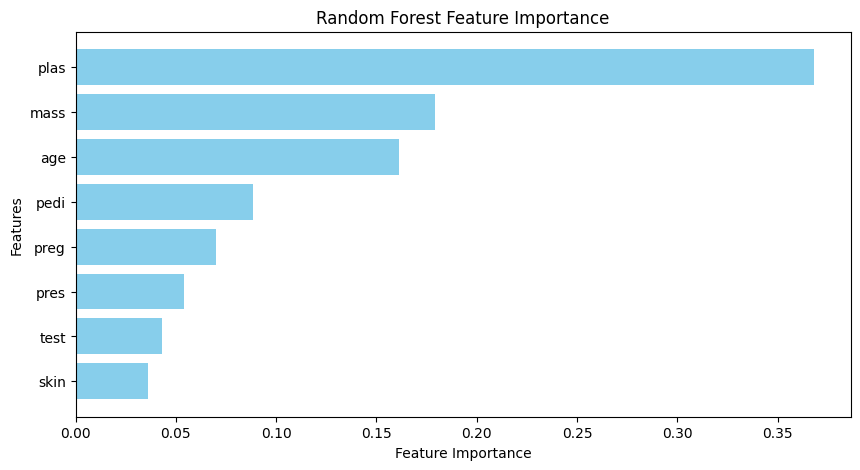

In [3]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Initialize Spark Session
spark = SparkSession.builder.appName("Pima_RF_Classifier").getOrCreate()

# Load dataset
file_path = "/content/drive/MyDrive/BDA/Dataset/pima.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show dataset structure
df.printSchema()
df.show(5)

# Data Preprocessing
# Prepare features (exclude last column, which is the label)
feature_columns = df.columns[:-1]

# Assemble features into a single column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df).select("features", col("class").alias("label"))

# Show transformed data
df.show(5)

# Split data into training and test sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Train model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, maxDepth=5, seed=42)
rf_model = rf.fit(train_df)

# Make predictions
predictions = rf_model.transform(test_df)
predictions.select("features", "label", "prediction").show(10)

# Evaluate accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.4f}")

# Visualize feature importance
# Get feature importances from the trained model
importances = list(zip(feature_columns, rf_model.featureImportances.toArray()))
importances.sort(key=lambda x: x[1], reverse=True)
# Feature importance
feature_importances = rf_model.featureImportances
for i, col_name in enumerate(feature_columns):
    print(f"{col_name}: {feature_importances[i]:.4f}")
# Plot feature importances
plt.figure(figsize=(10, 5))
plt.barh([x[0] for x in importances], [x[1] for x in importances], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Stop Spark session
spark.stop()
